In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
import os
import gc

def print_ram_usage():
    process = psutil.Process(os.getpid())
    ram_gb = process.memory_info().rss / (1024 ** 3)
    print(f"Current RAM usage: {ram_gb:.2f} GB")

print_ram_usage()

Current RAM usage: 0.19 GB


In [5]:
## 1. Load Data in Memory-Efficient Way

# Use dtype specification and chunking if needed
# ISBN is string, User-ID int32 to save memory

dtypes_books = {
    'ISBN': 'str',
    'Book-Title': 'str',
    'Book-Author': 'str',
    'Year-Of-Publication': 'str',  
    'Publisher': 'str',
    'Image-URL-S': 'str',
    'Image-URL-M': 'str',
    'Image-URL-L': 'str'
}

dtypes_users = {
    'User-ID': 'int32',
    'Location': 'str',
    'Age': 'float64'
}

dtypes_ratings = {
    'User-ID': 'int32',
    'ISBN': 'str',
    'Book-Rating': 'int8'  # 0-10 fits in int8
}

# Load
books = pd.read_csv('data/raw/Books.csv', dtype=dtypes_books, low_memory=False)
users = pd.read_csv('data/raw/Users.csv', dtype=dtypes_users)
ratings = pd.read_csv('data/raw/Ratings.csv', dtype=dtypes_ratings)

print(f"Books: {books.shape}")
print(f"Users: {users.shape}")
print(f"Ratings: {ratings.shape}")
print_ram_usage()

Books: (271360, 8)
Users: (278858, 3)
Ratings: (1149780, 3)
Current RAM usage: 0.41 GB


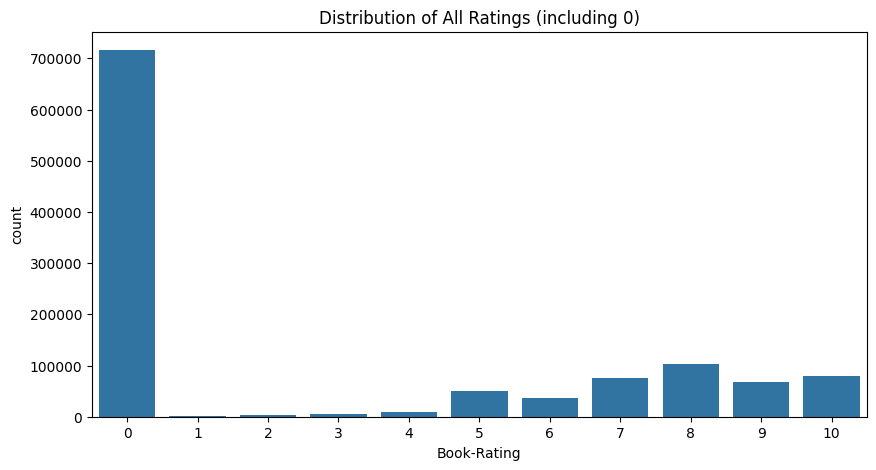

Explicit ratings (>0): 433671 out of 1149780 total ratings
Sparsity of explicit ratings: 0.999994


In [6]:
## 2. Basic Exploration

# Ratings distribution (including 0s = implicit feedback)
plt.figure(figsize=(10,5))
sns.countplot(x='Book-Rating', data=ratings)
plt.title('Distribution of All Ratings (including 0)')
plt.show()

# Explicit ratings only (>0)
explicit_ratings = ratings[ratings['Book-Rating'] > 0]
print(f"Explicit ratings (>0): {len(explicit_ratings)} out of {len(ratings)} total ratings")
print(f"Sparsity of explicit ratings: {1 - len(explicit_ratings)/(len(users)*len(books)):.6f}")

In [7]:
## 3. Filtering Strategy (Critical for 8GB RAM)

###We need to reduce to ~50k–80k explicit ratings while keeping meaningful structure.

###Steps:
###1. Keep only explicit ratings (>0)
###2. Remove users with very few ratings
###3. Remove books with very few ratings
###4. Iteratively tighten thresholds until target size
###5. Ensure reasonable number of users and books

# Start with explicit ratings
df = explicit_ratings.copy()
gc.collect()

print(f"After explicit only: {len(df)} ratings")

# Initial thresholds
min_user_ratings = 20   # user must have rated at least 20 books
min_book_ratings = 20   # book must have at least 20 ratings

active_users = df['User-ID'].value_counts()[df['User-ID'].value_counts() >= min_user_ratings].index
popular_books = df['ISBN'].value_counts()[df['ISBN'].value_counts() >= min_book_ratings].index

df = df[df['User-ID'].isin(active_users) & df['ISBN'].isin(popular_books)]
print(f"After min 20 ratings per user/book: {len(df)} ratings")
print(f"Users: {df['User-ID'].nunique()}, Books: {df['ISBN'].nunique()}")

After explicit only: 433671 ratings
After min 20 ratings per user/book: 47610 ratings
Users: 3404, Books: 2178


In [8]:
## 4. Further Downsampling if Needed

# Target: 50k–80k ratings (safe for LightGCN on CPU)
target_max = 80000

if len(df) > target_max:
    print("Still too large → further filtering")
    
    # Option A: Increase thresholds
    min_user_ratings = 30
    min_book_ratings = 30
    
    active_users = df['User-ID'].value_counts()[df['User-ID'].value_counts() >= min_user_ratings].index
    popular_books = df['ISBN'].value_counts()[df['ISBN'].value_counts() >= min_book_ratings].index
    
    df = df[df['User-ID'].isin(active_users) & df['ISBN'].isin(popular_books)]
    
    print(f"After stricter thresholds: {len(df)} ratings")
    print(f"Users: {df['User-ID'].nunique()}, Books: {df['ISBN'].nunique()}")

# Option B: If still too big, randomly sample users
if len(df) > target_max:
    print("Still large → random sampling of users")
    np.random.seed(42)
    sample_users = np.random.choice(df['User-ID'].unique(), size=3000, replace=False)  # adjust
    df = df[df['User-ID'].isin(sample_users)]
    print(f"After user sampling: {len(df)} ratings")

print("\nFinal filtered dataset:")
print(f"Ratings: {len(df)}")
print(f"Users: {df['User-ID'].nunique()}")
print(f"Books: {df['ISBN'].nunique()}")
print_ram_usage()


Final filtered dataset:
Ratings: 47610
Users: 3404
Books: 2178
Current RAM usage: 0.43 GB


In [9]:
## 5. Merge Book Metadata for Later Use

# Keep only books that survived filtering
filtered_books = books[books['ISBN'].isin(df['ISBN'].unique())][['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']].copy()

# Basic cleaning of year
filtered_books['Year-Of-Publication'] = pd.to_numeric(filtered_books['Year-Of-Publication'], errors='coerce')
filtered_books = filtered_books[filtered_books['Year-Of-Publication'].between(1900, 2025)]

print(f"Filtered books with metadata: {len(filtered_books)}")

Filtered books with metadata: 2112


In [10]:
## 6. Save Filtered Data

# Create processed folder if not exists
os.makedirs('data/processed', exist_ok=True)

# Save
df.to_csv('data/processed/filtered_ratings.csv', index=False)
filtered_books.to_csv('data/processed/books_filtered.csv', index=False)

# Also save filtered user ids (optional)
filtered_users = users[users['User-ID'].isin(df['User-ID'].unique())]
filtered_users.to_csv('data/processed/users_filtered.csv', index=False)

print("Saved filtered data:")
print("- filtered_ratings.csv")
print("- books_filtered.csv")
print("- users_filtered.csv")
print_ram_usage()

Saved filtered data:
- filtered_ratings.csv
- books_filtered.csv
- users_filtered.csv
Current RAM usage: 0.43 GB


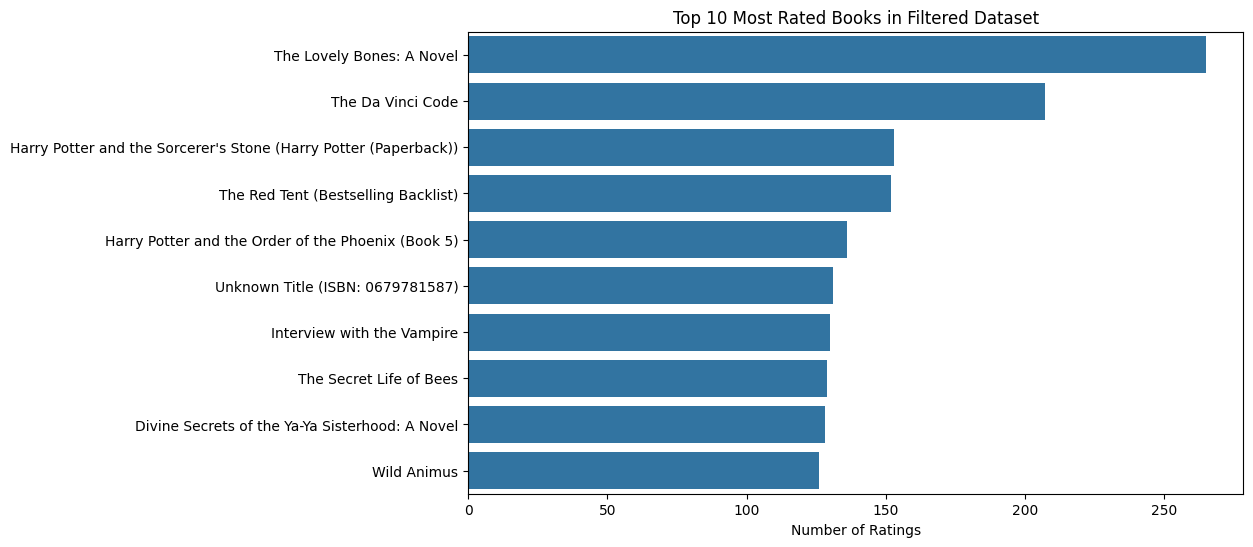

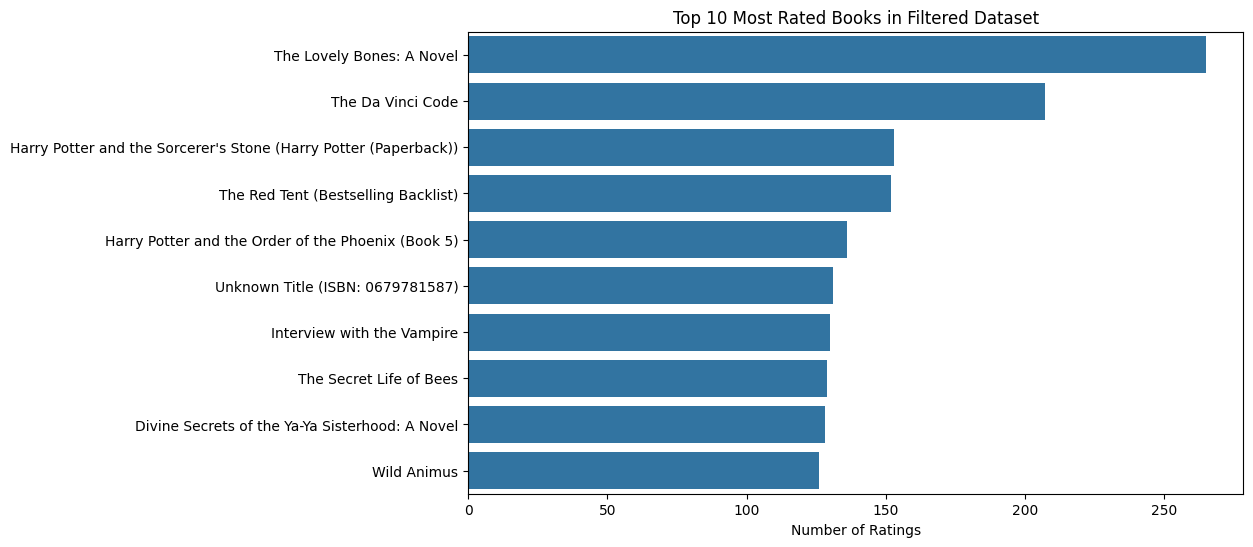

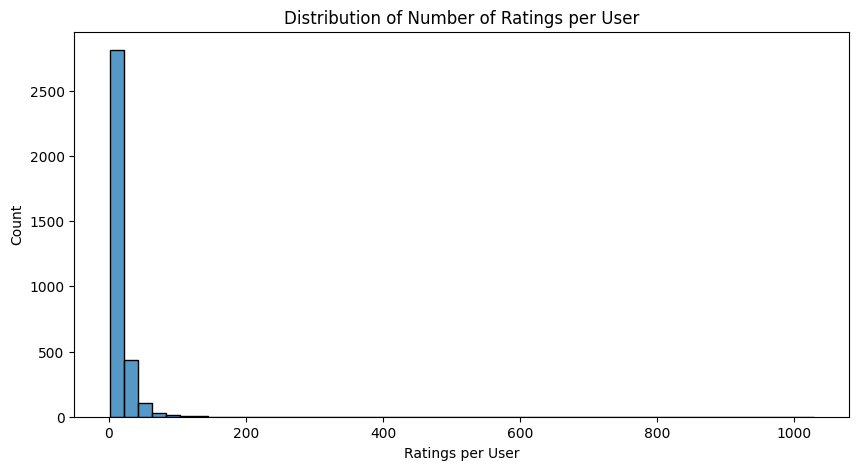

Final dataset ready for graph construction!
Peak RAM during this notebook: check above prints (should stay <6 GB)


In [ ]:
## 7. Final Summary Visualization (Fixed Version)

# Top 10 most rated books in filtered set
top_books = df['ISBN'].value_counts().head(10)

# Safely merge titles (left join to keep all top ISBNs)
top_titles_df = pd.DataFrame({'ISBN': top_books.index})
top_titles_df = top_titles_df.merge(
    filtered_books[['ISBN', 'Book-Title']], 
    on='ISBN', 
    how='left'
)
top_titles_df['Book-Title'] = top_titles_df['Book-Title'].fillna('Unknown Title (ISBN only)')

# Use the titles (with fallbacks)
titles = top_titles_df['Book-Title'].values
counts = top_books.values

plt.figure(figsize=(12, 8))
sns.barplot(x=counts, y=titles)
plt.title('Top 10 Most Rated Books in Filtered Dataset')
plt.xlabel('Number of Ratings')
plt.ylabel('Book Title')
plt.tight_layout()
plt.show()